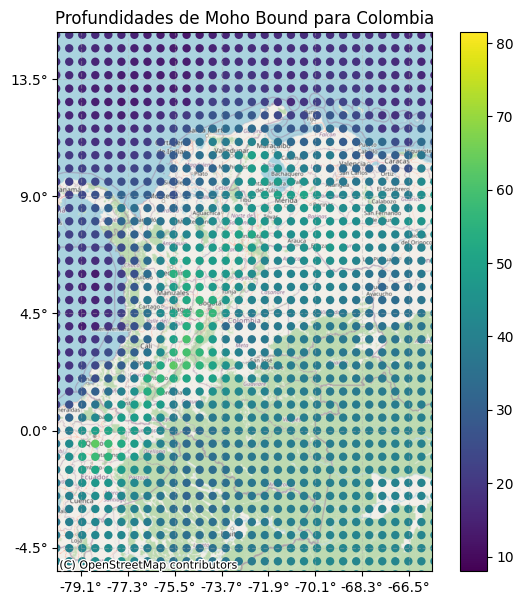

In [28]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter
# Ruta al archivo shapefile (.shp)
ruta = r"C:\Git_SCA\AGE\Corteza"  # Usa r"" para evitar problemas con backslashes
# Cargar el shapefile
gdf = gpd.read_file(ruta)
# Reproyectar al sistema de Web Mercator (requerido por contextily)
gdf = gdf.to_crs(epsg=3857)
# Función para convertir de Web Mercator a grados decimales (aproximado)
def mercator_to_lon(x, _):
    return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _):
    return f"{y * 180 / 20037508.34:.1f}°"
# Crear el gráfico
fig, ax = plt.subplots(figsize=(7, 7))
# Graficar el shapefile con color según 'Z'
gdf.plot(
    column='Z',
    cmap='viridis',
    legend=True,
    ax=ax,
    linewidth=0.01,
    edgecolor='black'
)
# Centrar el mapa en Colombia (coordenadas en Web Mercator)
ax.set_xlim([-8900000, -7300000])
ax.set_ylim([-600000, 1700000])
# Formatear los ejes con coordenadas bonitas
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
# Añadir líneas de grilla suaves
ax.grid(True, which='major', linestyle='--', alpha=0.4)
# Añadir el mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
# Título y visualización
plt.title("Profundidades de Moho Bound para Colombia")
#ax.set_axis_off()  # Si prefieres mostrar solo el mapa sin ejes, descomenta esta línea
plt.show()

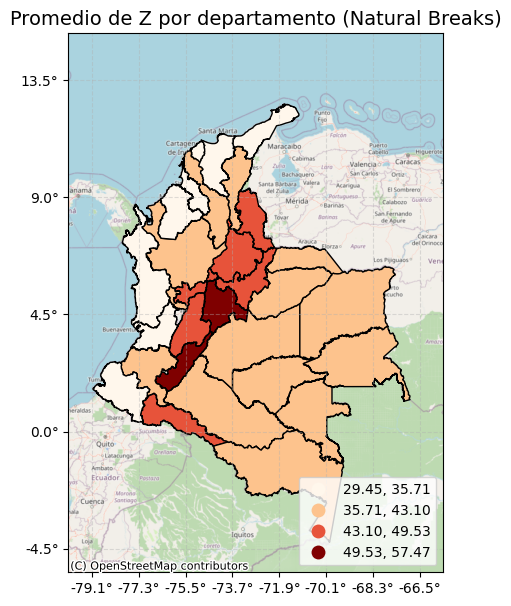

In [37]:

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# Ruta al shapefile con columna 'Z'
ruta_z = r"C:/Git_SCA\AGE/Corteza"
gdf = gpd.read_file(ruta_z)

# Ruta al shapefile de departamentos (polígonos)
ruta_dpto = r"C:/Git_SCA/AGE/departamentos"
departamentos = gpd.read_file(ruta_dpto)

# Asegurar mismo CRS
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)
if departamentos.crs != gdf.crs:
    departamentos = departamentos.to_crs(gdf.crs)

# Spatial join: asociar puntos/zonas con 'Z' a departamentos
joined = gpd.sjoin(gdf, departamentos, predicate='within')

# Calcular promedio de Z por departamento (ajusta el nombre si no es 'NOMBRE_DPT')
promedios = joined.groupby('DeNombre')['Z'].mean().reset_index()
promedios.rename(columns={'Z': 'Z_promedio'}, inplace=True)

# Unir promedios al GeoDataFrame de departamentos
departamentos = departamentos.merge(promedios, on='DeNombre', how='left')

# Reproyectar para contexto de mapa base
departamentos = departamentos.to_crs(epsg=3857)

# Funciones para mostrar ejes en grados
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"

# Crear figura y eje
fig, ax = plt.subplots(1, figsize=(7, 7))

# Mapa tipo choropleth
departamentos.plot(
    column='Z_promedio',
    cmap='OrRd',
    scheme='natural_breaks',
    k=4,
    legend=True,
    edgecolor='black',
    legend_kwds={'loc': 'lower right'},
    ax=ax
)

# Limitar a Colombia (EPSG:3857)
ax.set_xlim([-8900000, -7300000])
ax.set_ylim([-600000, 1700000])

# Ejes bonitos en grados
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
ax.grid(True, linestyle="--", alpha=0.4)

# Mapa base estándar de OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:3857')

# Título del mapa
ax.set_title("Promedio de Z por departamento (Natural Breaks)", fontsize=14)
plt.show()


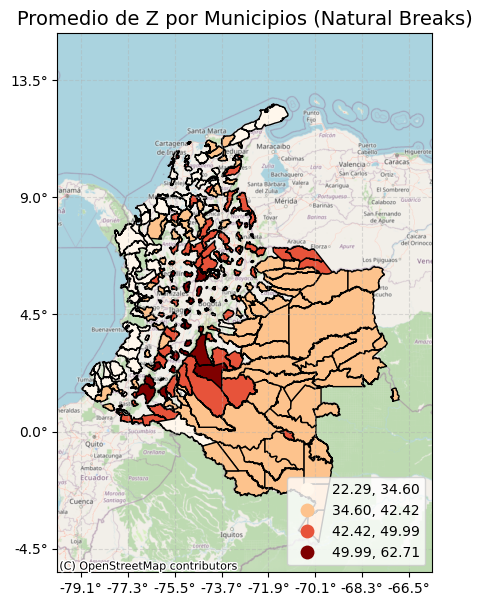

In [39]:

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# Ruta al shapefile con columna 'Z'
ruta_z = r"C:/Git_SCA\AGE/Corteza"
gdf = gpd.read_file(ruta_z)

# Ruta al shapefile de departamentos (polígonos)
ruta_dpto = r"C:/Git_SCA/AGE/municipios"
municipios = gpd.read_file(ruta_dpto)

# Asegurar mismo CRS
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)
if municipios.crs != gdf.crs:
    municipios = municipios.to_crs(gdf.crs)

# Spatial join: asociar puntos/zonas con 'Z' a departamentos
joined = gpd.sjoin(gdf, municipios, predicate='within')

# Calcular promedio de Z por departamento (ajusta el nombre si no es 'NOMBRE_DPT')
promedios = joined.groupby('MpNombre')['Z'].mean().reset_index()
promedios.rename(columns={'Z': 'Z_promedio'}, inplace=True)

# Unir promedios al GeoDataFrame de departamentos
municipios = municipios.merge(promedios, on='MpNombre', how='left')

# Reproyectar para contexto de mapa base
municipios = municipios.to_crs(epsg=3857)

# Funciones para mostrar ejes en grados
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"

# Crear figura y eje
fig, ax = plt.subplots(1, figsize=(7, 7))

# Mapa tipo choropleth
municipios.plot(
    column='Z_promedio',
    cmap='OrRd',
    scheme='natural_breaks',
    k=4,
    legend=True,
    edgecolor='black',
    legend_kwds={'loc': 'lower right'},
    ax=ax
)

# Limitar a Colombia (EPSG:3857)
ax.set_xlim([-8900000, -7300000])
ax.set_ylim([-600000, 1700000])

# Ejes bonitos en grados
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
ax.grid(True, linestyle="--", alpha=0.4)

# Mapa base estándar de OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:3857')

# Título del mapa
ax.set_title("Promedio de Z por Municipios (Natural Breaks)", fontsize=14)
plt.show()


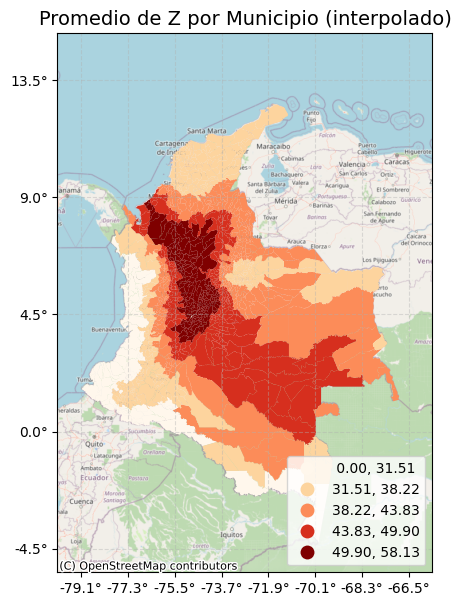

In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter
from rasterstats import zonal_stats
import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import box
import rasterio
from rasterio.transform import from_origin

# Cargar puntos con Z
ruta_z = r"C:/Git_SCA/AGE/Corteza"
gdf = gpd.read_file(ruta_z)
gdf = gdf.to_crs(epsg=3857)

# Cargar municipios
ruta_mpios = r"C:/Git_SCA/AGE/municipios"
municipios = gpd.read_file(ruta_mpios)
municipios = municipios.to_crs(epsg=3857)

# Crear una grilla sobre Colombia
minx, miny, maxx, maxy = -8900000, -600000, -7300000, 1700000
res = 5000  # resolución de grilla en metros

x = np.arange(minx, maxx, res)
y = np.arange(miny, maxy, res)
xx, yy = np.meshgrid(x, y)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# IDW Interpolation
xy = np.vstack((gdf.geometry.x, gdf.geometry.y)).T
tree = cKDTree(xy)
distances, indices = tree.query(grid_points, k=8)
weights = 1 / (distances + 1e-8)
z_vals = np.sum(weights * gdf['Z'].values[indices], axis=1) / np.sum(weights, axis=1)

# Crear raster interpolado
z_grid = z_vals.reshape(xx.shape)
transform = from_origin(minx, maxy, res, res)

# Guardar raster temporal
raster_path = "interpolacion_z.tif"
with rasterio.open(
    raster_path,
    'w',
    driver='GTiff',
    height=z_grid.shape[0],
    width=z_grid.shape[1],
    count=1,
    dtype='float32',
    crs='EPSG:3857',
    transform=transform,
) as dst:
    dst.write(z_grid.astype('float32'), 1)

# Calcular promedio de Z por municipio desde el raster interpolado
stats = zonal_stats(municipios, raster_path, stats="mean", geojson_out=True)
municipios_interp = gpd.GeoDataFrame.from_features(stats)
municipios_interp.rename(columns={"mean": "Z_promedio"}, inplace=True)

# Crear gráfico
fig, ax = plt.subplots(1, figsize=(7, 7))
municipios_interp.plot(
    column='Z_promedio',
    cmap='OrRd',
    scheme='natural_breaks',
    k=5,
    legend=True,
    legend_kwds={'loc': 'lower right'},
    ax=ax
)

# Limitar a Colombia
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# Ejes en grados
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
ax.grid(True, linestyle="--", alpha=0.4)

# Mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:3857')

plt.title("Promedio de Z por Municipio (interpolado)", fontsize=14)
plt.show()


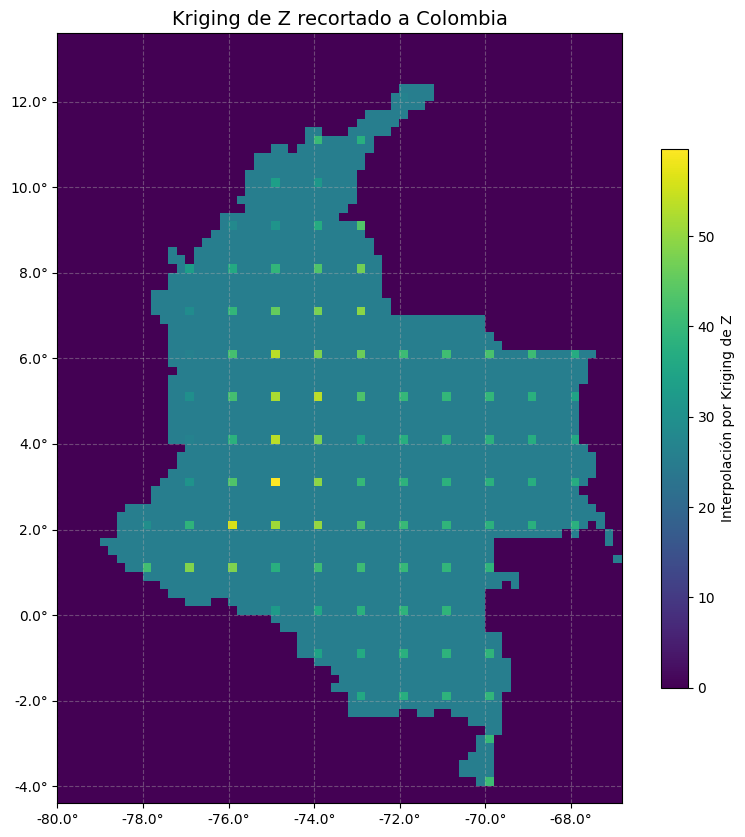

In [60]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
import rasterio
from rasterio.transform import from_origin
from rasterio.mask import mask
from matplotlib.ticker import FuncFormatter
import tempfile
import os

# === 1. Cargar puntos y transformar a EPSG:4326 ===
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
x = gdf.geometry.x.values
y = gdf.geometry.y.values
z = gdf['Z'].values

# === 2. Cargar shapefile de Colombia (EPSG:4326) ===
colombia = gpd.read_file(r"C:/Git_SCA/AGE/colombia", layer='co').to_crs(epsg=4326)
colombia = colombia[~colombia.geometry.is_empty & colombia.geometry.is_valid]

# Si no se carga, usar un bbox
if colombia.empty:
    from shapely.geometry import box
    bbox = box(-80, -5, -66, 15)
    colombia = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

# === 3. Crear grilla regular ===
x_min, x_max = -80, -66
y_min, y_max = -5, 15
res = 0.2  # resolución en grados
gridx = np.arange(x_min, x_max, res)
gridy = np.arange(y_min, y_max, res)

# === 4. Interpolación por Kriging ===
OK = OrdinaryKriging(x, y, z, variogram_model='linear', verbose=False, enable_plotting=False)
z_interp, ss = OK.execute('grid', gridx, gridy)

# === 5. Guardar raster temporal ===
transform = from_origin(x_min, y_max, res, res)
temp_tif = tempfile.NamedTemporaryFile(delete=False, suffix=".tif").name
with rasterio.open(
    temp_tif, 'w', driver='GTiff',
    height=z_interp.shape[0], width=z_interp.shape[1],
    count=1, dtype='float32', crs='EPSG:4326', transform=transform
) as dst:
    dst.write(np.flipud(z_interp).astype('float32'), 1)

# === 6. Recorte con Colombia ===
with rasterio.open(temp_tif) as src:
    out_image, out_transform = mask(src, colombia.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# === 7. Mostrar resultado ===
fig, ax = plt.subplots(figsize=(10, 10))
show_data = out_image[0]
extent = [
    out_transform[2],
    out_transform[2] + out_transform[0] * show_data.shape[1],
    out_transform[5] + out_transform[4] * show_data.shape[0],
    out_transform[5]
]
img = ax.imshow(show_data, extent=extent, cmap='viridis', origin='upper')

# Coordenadas en grados
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}°"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}°"))
ax.grid(True, linestyle="--", alpha=0.4)

# Leyenda y título
plt.colorbar(img, ax=ax, shrink=0.7, label="Interpolación por Kriging de Z")
plt.title("Kriging de Z recortado a Colombia", fontsize=14)
plt.show()

# Borrar archivo temporal
os.remove(temp_tif)
